In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models
import seaborn as sns
from scipy import interpolate

In [8]:
plt.style.use('../paper/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches

### calling in 10k merger tree realizations

### first the variance in the data

In [9]:
from scipy.stats import ks_2samp

def lnL_PNsat(data, model):
    lnL = np.sum(np.log(model.PNsat[data.Nsat_perhost]))
    if np.isinf(lnL):
        #print("index error in Pnsat")
        return -np.inf
    else:
        return lnL

def lnL_KS_max(data, model):
    try:
        clean_max_split = list(map(model.max_split.__getitem__, data.model_mask)) # this might yield an index error!
        p_vals = np.array(list(map(lambda x, y: ks_2samp(x, y)[1], data.clean_max_split, clean_max_split)))
        return np.sum(np.log(p_vals))
    except IndexError:
        #print("this model is not preferable!")
        return -np.inf

In [10]:
def measure_lnLvar_M(Nhost_per_model, SAGA_ind, fid_theta=[10.5, 2.0, 0,0, 0.0, 0.2, 0.0], min_mass=6.5):
    
    #print("selecting the", SAGA_ind, "SAGA index")    
    class_i = jsm_models.SAMPLE_CROSS(fid_theta, meta_path="../../../data/cross_host/lognorm_030_psi3/", SAGA_ind=SAGA_ind, verbose=False)
    Dstat_i = jsm_stats.SatStats_D(class_i.lgMs_data, min_mass, max_N=500)

    Nhost_extra = class_i.lgMs_model.shape[0] % Nhost_per_model
    if Nhost_extra == 0:
        N_models = int(class_i.lgMs_model.shape[0] / Nhost_per_model)
        class_i.lgMs_model = class_i.lgMs_model.reshape([N_models, Nhost_per_model, class_i.lgMs_model.shape[1]])
    else:
        class_i.lgMs_model = np.delete(class_i.lgMs_model, np.arange(Nhost_extra), axis=0)
        N_models = int(class_i.lgMs_model.shape[0] / Nhost_per_model)
        class_i.lgMs_model = class_i.lgMs_model.reshape([N_models, Nhost_per_model,  class_i.lgMs_model.shape[1]])

    # print("When Nhost = ", Nhost_per_model, ",there are", Nhost_extra, "extra trees. That leaves", N_models, "model realizations")
    # print(class_i.lgMs_model.shape)

    lnLs = []
    for model in class_i.lgMs_model:
        Mstat_i = jsm_stats.SatStats_M(model, min_mass, max_N=500)
        lnL_i = lnL_PNsat(Dstat_i, Mstat_i) + lnL_KS_max(Dstat_i, Mstat_i)
        lnLs.append(lnL_i)

    lnLs = np.array(lnLs)
    inf_mask = np.isinf(lnLs)
    Ndrops = np.sum(inf_mask)/lnLs.shape[0]
    lnLs_clean = lnLs[~inf_mask]
    return lnLs_clean.std(ddof=1), Ndrops

In [17]:
var = []
drop = []

for i,index in enumerate(range(100)):
    var_ij, drop_ij = measure_lnLvar_M(Nhost_per_model=2000, SAGA_ind=index)
    var.append(var_ij)
    drop.append(drop_ij)

In [22]:
np.std(1-np.array(drop))

0.37762415176998415

(array([15.,  0., 25.,  0.,  0., 11.,  0., 15.,  0., 34.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

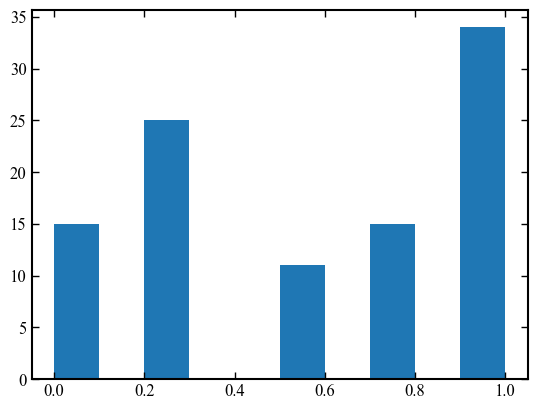

In [20]:
plt.hist(1-np.array(drop))

In [8]:
# Nhost = np.logspace(1.1,3, 25).astype(int)

# Nsaga = 100

# var_mat = np.full((Nsaga, Nhost.shape[0]), np.nan)
# drop_mat = np.full((Nsaga, Nhost.shape[0]), np.nan)

# for i,index in enumerate(range(Nsaga)):
#     for j,Nmod in enumerate(Nhost):
#         var_ij, drop_ij = measure_lnLvar_M(Nhost_per_model=Nmod, SAGA_ind=index)
#         var_mat[i,j] = var_ij
#         drop_mat[i,j] = drop_ij

# np.save("../../mcmc/inference_tests/convergence/data_saves/drop_S30.npy", drop_mat)
# np.save("../../mcmc/inference_tests/convergence/data_saves/var_S30.npy", var_mat)